 # Mini Project 2 - Discovering New Dimensions for Houses in Ames, Iowa<br> 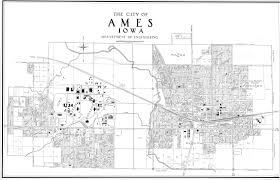

In [1]:
# load Required Libraries
# IMPORT DATA SCIENCE LIBRARIES
import pandas as pd
import numpy as np
import math
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist 
from matplotlib import pyplot as plt

# Display plots in Jupypter Notebooks
%matplotlib inline

# IMPORT SKLEARN FUNCTIONS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.cluster import KMeans
from sklearn import neighbors, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import homogeneity_score

In [2]:
# Load the AMES Housing Dataset
house = pd.read_csv("AmesHousing.csv")

In [3]:
# What does the dataframe look like?
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order          2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   MSSubClass     2930 non-null   int64  
 3   MSZoning       2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

In [4]:
# Are there any NAN values?
house.isna().sum()

Order              0
PID                0
MSSubClass         0
MSZoning           0
LotFrontage      490
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 82, dtype: int64

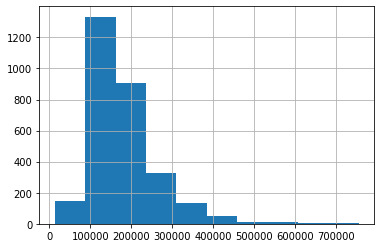

In [5]:
# Sale Price - Histograph
# Not a normal distribution - right tail
house["SalePrice"].hist()

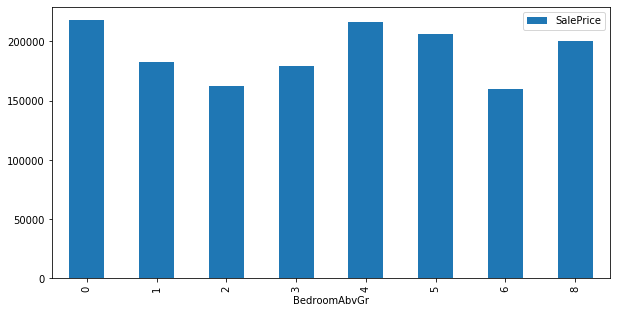

In [6]:
# House Prices by No of Bedrooms
bdmprice = house[['BedroomAbvGr','SalePrice']].copy()
bdmprice = bdmprice.groupby('BedroomAbvGr').agg("mean")
# Plot the mean price by number of bedrooms
bdmprice.plot.bar(figsize=[10,5])

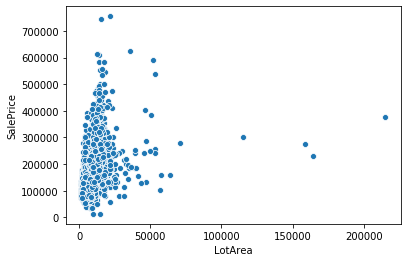

In [7]:
# Size of Land and Price
sns.scatterplot(x="LotArea", y="SalePrice", data=house)

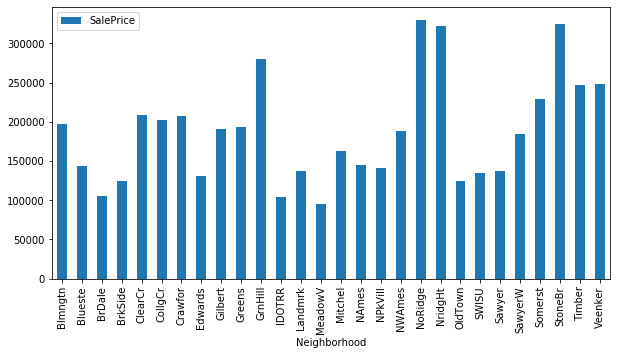

In [8]:
# Average Prices by Neighbourhood:
nhprice = house[['Neighborhood','SalePrice']].copy()
nhprice = nhprice.groupby('Neighborhood').agg('mean')
# Plot the result:
nhprice.plot.bar(figsize=[10,5])

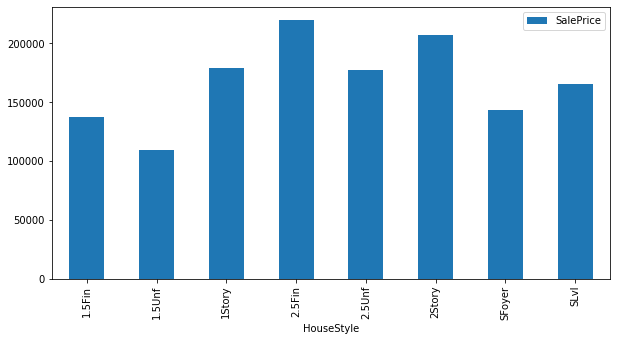

In [9]:
# Average Prices by House Style:
hsprice = house[['HouseStyle','SalePrice']].copy()
hsprice = hsprice.groupby('HouseStyle').agg('mean')
# Plot the result:
hsprice.plot.bar(figsize=[10,5])

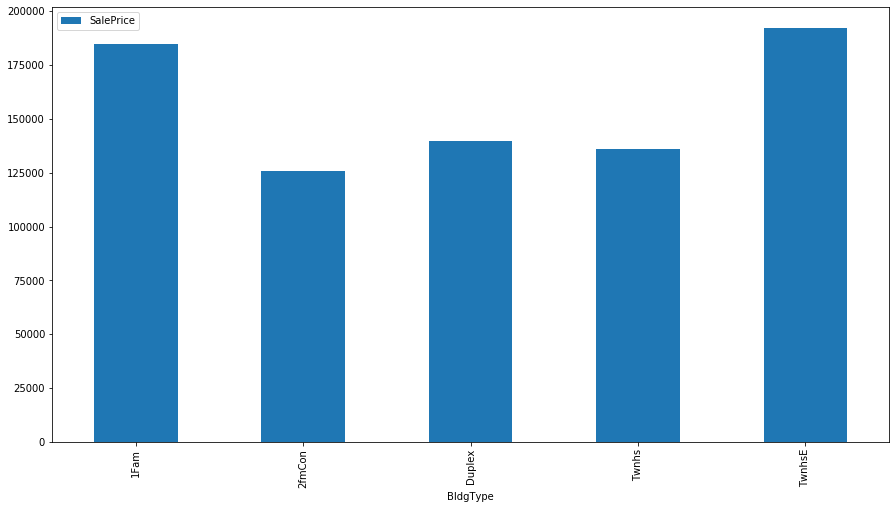

In [10]:
# Average Prices by Building Type:
btprice = house[['BldgType','SalePrice']].copy()
btprice = btprice.groupby('BldgType').agg('mean')
# Plot the result:
btprice.plot.bar(figsize=[15,8])

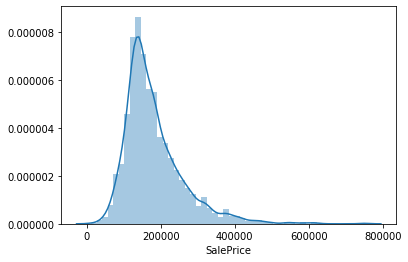

In [11]:
# SalePrice Distribution
sns.distplot(house.SalePrice)

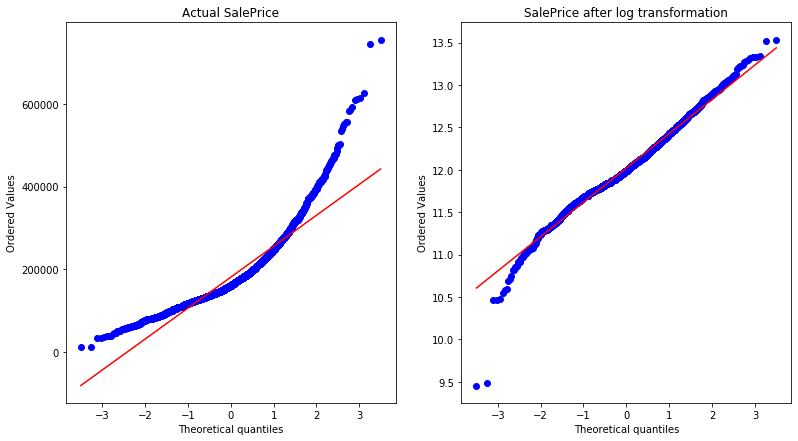

In [12]:
# This is not a normal distribution - Will a log transformation be useful?
# Adopted from Ames Housing Price Prediction — Complete ML Project with Python
# https://medium.com/@kamskijohnm2m/ames-housing-price-prediction-complete-ml-project-with-python-2af595a749d6

figure = plt.figure(figsize = (13,7))
plt.subplot(1,2,1)
stats.probplot(house.SalePrice, plot = plt)
plt.title('Actual SalePrice')
plt.subplot(1,2,2)
house.SalePrice = np.log(house.SalePrice)
stats.probplot(house.SalePrice, plot = plt)
plt.title('SalePrice after log transformation')
plt.show()

### EDA on Mean Prices for Categorical Variables

In [15]:
 # Adopted from  A study on Regression applied to the Ames dataset
 # https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset/data
 
def mean_prices_categorical_var(df):
  for i in df:
    if df[i].dtype == 'O':
      print(df.groupby(i, as_index=True)['SalePrice'].mean() )  
      print("\n")
      
print(mean_prices_categorical_var(df))

NameError: name 'df' is not defined

In [16]:
mean_prices_categorical_var(house)

MSZoning
A (agr)    10.394363
C (all)    11.209762
FV         12.269616
I (all)    11.252098
RH         11.785066
RL         12.086423
RM         11.692183
Name: SalePrice, dtype: float64


Street
Grvl    11.460912
Pave    12.023272
Name: SalePrice, dtype: float64


Alley
Grvl    11.680836
Pave    12.049770
Name: SalePrice, dtype: float64


LotShape
IR1    12.188836
IR2    12.283116
IR3    12.228756
Reg    11.920060
Name: SalePrice, dtype: float64


LandContour
Bnk    11.821641
HLS    12.336489
Low    12.061607
Lvl    12.014520
Name: SalePrice, dtype: float64


Utilities
AllPub    12.021521
NoSeWa    11.831379
NoSewr    11.307200
Name: SalePrice, dtype: float64


LotConfig
Corner     12.014076
CulDSac    12.249366
FR2        12.018717
FR3        12.109667
Inside     12.002913
Name: SalePrice, dtype: float64


LandSlope
Gtl    12.016555
Mod    12.102542
Sev    12.153046
Name: SalePrice, dtype: float64


Neighborhood
Blmngtn    12.178908
Blueste    11.856254
BrDale     11.560916
BrkSide 

## Process data for Linear Regression: <br>
### Adopted from: <br> A study on Regression applied to the Ames Dataset <br>
https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [20]:
# Load the AMES Housing Dataset
house = pd.read_csv("AmesHousing.csv")

#### Pre-Process Variables: <br> Update values for categorical data:

In [21]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
house.loc[:, "Alley"] = house.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
house.loc[:, "BedroomAbvGr"] = house.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
house.loc[:, "BsmtQual"] = house.loc[:, "BsmtQual"].fillna("No")
house.loc[:, "BsmtCond"] = house.loc[:, "BsmtCond"].fillna("No")
house.loc[:, "BsmtExposure"] = house.loc[:, "BsmtExposure"].fillna("No")
house.loc[:, "BsmtFinType1"] = house.loc[:, "BsmtFinType1"].fillna("No")
house.loc[:, "BsmtFinType2"] = house.loc[:, "BsmtFinType2"].fillna("No")
house.loc[:, "BsmtFullBath"] = house.loc[:, "BsmtFullBath"].fillna(0)
house.loc[:, "BsmtHalfBath"] = house.loc[:, "BsmtHalfBath"].fillna(0)
house.loc[:, "BsmtUnfSF"] = house.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
house.loc[:, "CentralAir"] = house.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
house.loc[:, "Condition1"] = house.loc[:, "Condition1"].fillna("Norm")
house.loc[:, "Condition2"] = house.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
house.loc[:, "EnclosedPorch"] = house.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
house.loc[:, "ExterCond"] = house.loc[:, "ExterCond"].fillna("TA")
house.loc[:, "ExterQual"] = house.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
house.loc[:, "Fence"] = house.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
house.loc[:, "FireplaceQu"] = house.loc[:, "FireplaceQu"].fillna("No")
house.loc[:, "Fireplaces"] = house.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
house.loc[:, "Functional"] = house.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
house.loc[:, "GarageType"] = house.loc[:, "GarageType"].fillna("No")
house.loc[:, "GarageFinish"] = house.loc[:, "GarageFinish"].fillna("No")
house.loc[:, "GarageQual"] = house.loc[:, "GarageQual"].fillna("No")
house.loc[:, "GarageCond"] = house.loc[:, "GarageCond"].fillna("No")
house.loc[:, "GarageArea"] = house.loc[:, "GarageArea"].fillna(0)
house.loc[:, "GarageCars"] = house.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
house.loc[:, "HalfBath"] = house.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
house.loc[:, "HeatingQC"] = house.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
house.loc[:, "KitchenAbvGr"] = house.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
house.loc[:, "KitchenQual"] = house.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
house.loc[:, "LotFrontage"] = house.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
house.loc[:, "LotShape"] = house.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
house.loc[:, "MasVnrType"] = house.loc[:, "MasVnrType"].fillna("None")
house.loc[:, "MasVnrArea"] = house.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
house.loc[:, "MiscFeature"] = house.loc[:, "MiscFeature"].fillna("No")
house.loc[:, "MiscVal"] = house.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
house.loc[:, "OpenPorchSF"] = house.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
house.loc[:, "PavedDrive"] = house.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
house.loc[:, "PoolQC"] = house.loc[:, "PoolQC"].fillna("No")
house.loc[:, "PoolArea"] = house.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
house.loc[:, "SaleCondition"] = house.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
house.loc[:, "ScreenPorch"] = house.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
house.loc[:, "TotRmsAbvGrd"] = house.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
house.loc[:, "Utilities"] = house.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
house.loc[:, "WoodDeckSF"] = house.loc[:, "WoodDeckSF"].fillna(0)






In [22]:
house.head

<bound method NDFrame.head of       Order        PID  MSSubClass MSZoning  LotFrontage  LotArea Street  \
0         1  526301100          20       RL        141.0    31770   Pave   
1         2  526350040          20       RH         80.0    11622   Pave   
2         3  526351010          20       RL         81.0    14267   Pave   
3         4  526353030          20       RL         93.0    11160   Pave   
4         5  527105010          60       RL         74.0    13830   Pave   
...     ...        ...         ...      ...          ...      ...    ...   
2925   2926  923275080          80       RL         37.0     7937   Pave   
2926   2927  923276100          20       RL          0.0     8885   Pave   
2927   2928  923400125          85       RL         62.0    10441   Pave   
2928   2929  924100070          20       RL         77.0    10010   Pave   
2929   2930  924151050          60       RL         74.0     9627   Pave   

     Alley LotShape LandContour  ... PoolArea PoolQC  Fen

#### Remove numeric values from Categorical Variables:

In [23]:
# Some numerical features are actually really categories
house.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}, "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}}, inplace=True)

### Encode categorical features as numeric.
#### Note: <br> This is method is preferred to create dummy. <br>Features are easily identified for comment after analysis.

In [24]:
# Encode some categorical features as ordered numbers when there is information in the order
house.replace({"Alley" : {"Grvl" : 1, "Pave" : 2}, "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},              "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},"BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
"BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},"BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}, "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},"ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}, "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},  "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8}, "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}, "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}, "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
"KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},"LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},"LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4}, "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},"PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},"Street" : {"Grvl" : 1, "Pave" : 2},
"Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}} ,inplace=True)

#### Setup X, y variables for Linear Regression <br> All Numeric variables from the dataset is used for the initial baseline accuracy <br> No Transformations


In [47]:
# X - Multi- Variable Regression
# 35 Correlated Numeric Variable to SalePrice
X = house[['OverallQual','GrLivArea','GarageCars','GarageArea', 'TotalBsmtSF','YearBuilt','1stFlrSF','YearRemod/Add','GarageYrBlt','FullBath','TotRmsAbvGrd','Fireplaces', 'MasVnrArea','BsmtFinSF1','LotFrontage','WoodDeckSF', 'OpenPorchSF','HalfBath','BsmtFullBath','2ndFlrSF','LotArea','BsmtUnfSF','BedroomAbvGr','ScreenPorch','PoolArea','3SsnPorch','BsmtFinSF2','MiscVal','BsmtHalfBath','Order','YrSold','LowQualFinSF','OverallCond','KitchenAbvGr','EnclosedPorch', 'SalePrice']]
y = X.SalePrice

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    2930 non-null   int64  
 1   GrLivArea      2930 non-null   int64  
 2   GarageCars     2930 non-null   float64
 3   GarageArea     2930 non-null   float64
 4   TotalBsmtSF    2929 non-null   float64
 5   YearBuilt      2930 non-null   int64  
 6   1stFlrSF       2930 non-null   int64  
 7   YearRemod/Add  2930 non-null   int64  
 8   GarageYrBlt    2771 non-null   float64
 9   FullBath       2930 non-null   int64  
 10  TotRmsAbvGrd   2930 non-null   int64  
 11  Fireplaces     2930 non-null   int64  
 12  MasVnrArea     2930 non-null   float64
 13  BsmtFinSF1     2929 non-null   float64
 14  LotFrontage    2930 non-null   float64
 15  WoodDeckSF     2930 non-null   int64  
 16  OpenPorchSF    2930 non-null   int64  
 17  HalfBath       2930 non-null   int64  
 18  BsmtFull

In [28]:
# The SalePrice is no longer required:
X.drop("SalePrice", axis=1,inplace=True)

In [49]:
# Remove blanks - Replace with 0
X.fillna(0,inplace=True)

In [50]:
# split data into training and testing sections
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = 0.2)

In [51]:
# Baeline Linear Regression:
lr = LinearRegression()

In [52]:
# Fit Test Data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
# Fit Train Data
lr.fit(X_test,y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# Adopted from :
# A study on Regression applied to the Ames dataset

# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset/data


# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [54]:
# Look at predictions on training and validation set
print("RMSE on Training set : ", rmse_cv_train(lr).mean())
print("RMSE on Test set : ", rmse_cv_test(lr).mean())

RMSE on Training set :  4.314562943554995e-11
RMSE on Test set :  4.116901288170872e-11


In [55]:
#Calculate the predictor
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

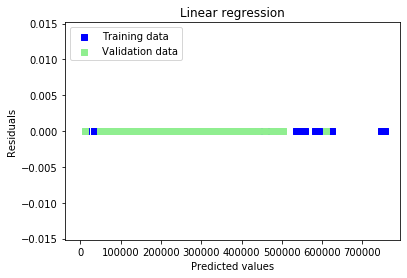

In [56]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


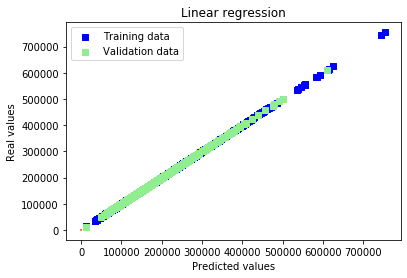

In [57]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()


### Linear Regression with same X variables and log transformation for y

In [88]:
# use the log function on SalePrice
y_log = np.log1p(house.SalePrice)

In [89]:
# X Standardised
X_std = StandardScaler().fit_transform(X)

In [90]:
# Fit Train Data
lr.fit(X_test,y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
# Fit Test Data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
# split data into training and testing sections
X_train, X_test, y_train, y_test = train_test_split(X_std, y_log, random_state=1, test_size = 0.2)

In [93]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [94]:
# Look at predictions on training and validation set
print("RMSE on Training set : ", rmse_cv_train(lr).mean())
print("RMSE on Test set : ", rmse_cv_test(lr).mean())

RMSE on Training set :  0.16950479208019437
RMSE on Test set :  0.1541193098644396


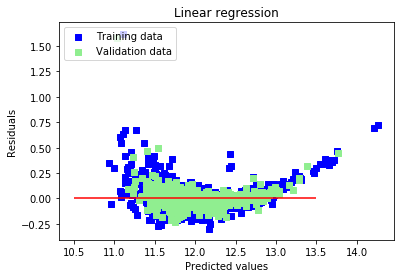

In [95]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


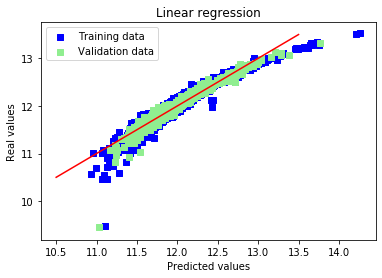

In [96]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

### Feature Reduction with Correlation Matrix:

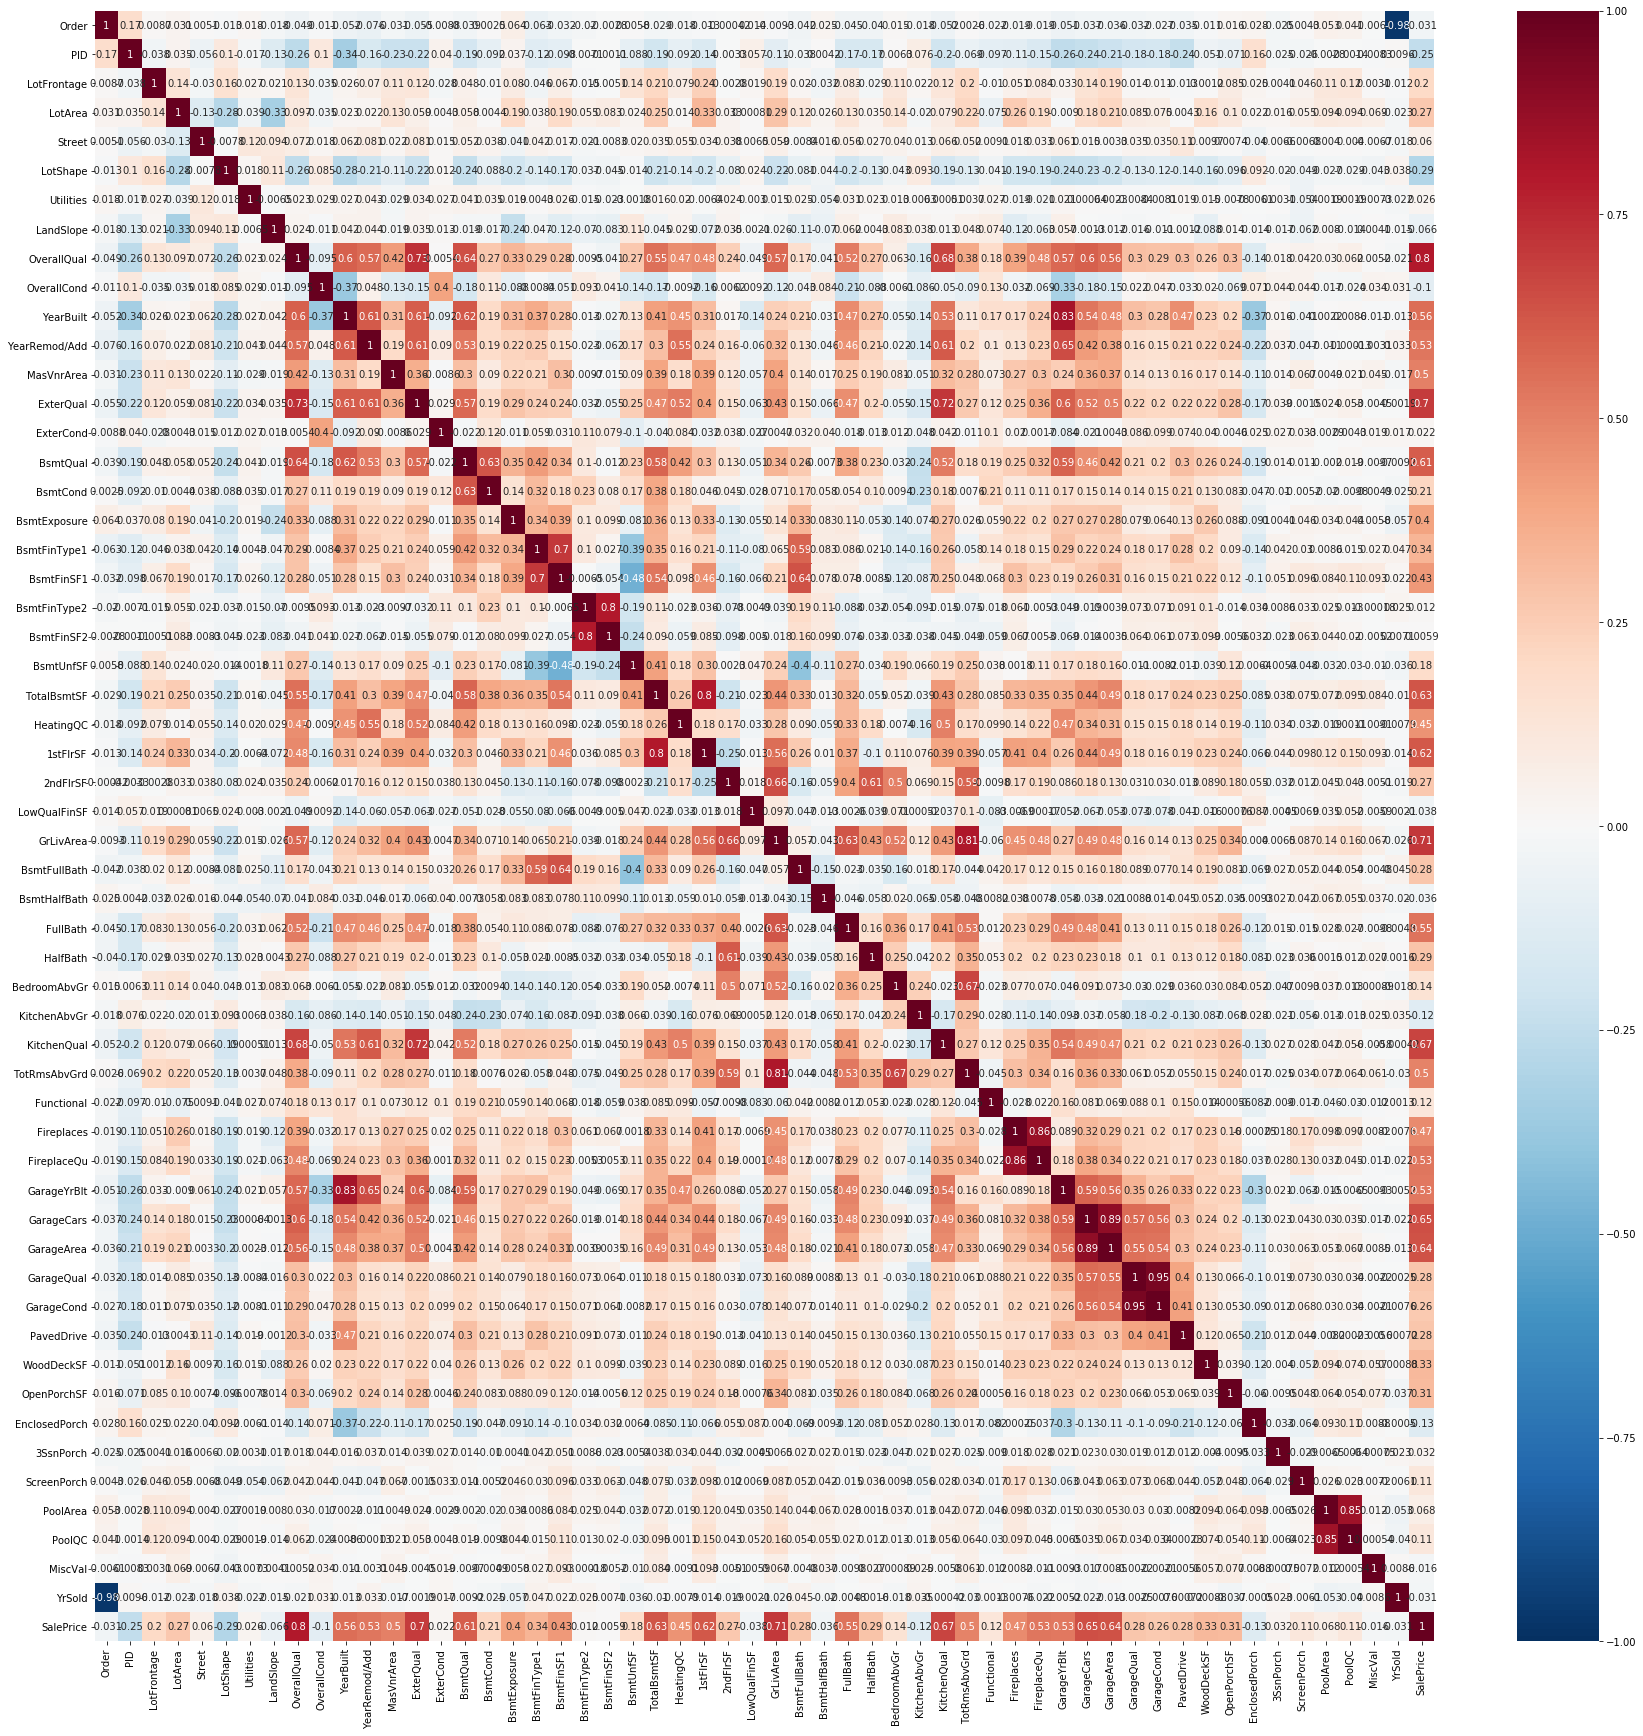

In [67]:
# Correlation of Numeric Features to the Sale Price:

corr = house.corr()
plt.figure(figsize = (30,30))
# sns.heatmap(corr, 
#            xticklabels=corr.columns.values,
#            yticklabels=corr.columns.values)
heatmap = sns.heatmap(corr, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

### There are 54 Varaiables in the Correlation Matrix

In [68]:
# This is very difficult to read:
# This corrolation matrix can be converted to a dictionary and then a list:

# Adpoted from:
# Quantitative Data Exploration for Regression in Python (Ames Housing Dataset)
# https://medium.com/@hjhuney/quantitative-data-exploration-for-regression-in-python-ames-housing-part-1-25879dd4cc4a

corr_list = sorted(house.corr().to_dict()['SalePrice'].items(), key=lambda x: x[1], reverse=True)
corr_list

[('SalePrice', 1.0),
 ('OverallQual', 0.7992617947690226),
 ('GrLivArea', 0.706779920976627),
 ('ExterQual', 0.6979699339863578),
 ('KitchenQual', 0.6729135077676074),
 ('GarageCars', 0.6475616131207692),
 ('GarageArea', 0.6401382984873747),
 ('TotalBsmtSF', 0.632280457106513),
 ('1stFlrSF', 0.6216760632702544),
 ('BsmtQual', 0.6075315574118847),
 ('YearBuilt', 0.5584261057120451),
 ('FullBath', 0.5456039005201111),
 ('FireplaceQu', 0.5339007780053421),
 ('YearRemod/Add', 0.5329737540266942),
 ('GarageYrBlt', 0.5269653487423954),
 ('MasVnrArea', 0.5021959770445463),
 ('TotRmsAbvGrd', 0.49547441685703353),
 ('Fireplaces', 0.4745580925917722),
 ('HeatingQC', 0.45032465412429307),
 ('BsmtFinSF1', 0.4329144106073928),
 ('BsmtExposure', 0.3997697024945313),
 ('BsmtFinType1', 0.33696521263929713),
 ('WoodDeckSF', 0.32714317398316844),
 ('OpenPorchSF', 0.312950505662715),
 ('HalfBath', 0.2850560315387106),
 ('GarageQual', 0.2779519375480125),
 ('PavedDrive', 0.2759641690558217),
 ('BsmtFullBa

In [69]:
# Save the list to a dataframe
fs_list = pd.DataFrame(corr_list)

In [71]:
# Rename the columns in the feature set dataframe
fs_list.rename(columns = {0:'Attribute',1:'CorrValue'}, inplace=True)

In [76]:
# For Feature selection:
for row in range(0, len(fs_list)):
    icorr = fs_list["CorrValue"].iloc[row]
    if icorr > 0.55:
         print(fs_list["Attribute"].iloc[row])
        # print(fs_list.iloc[row])
         print (fs_list["CorrValue"].iloc[row])

SalePrice
1.0
OverallQual
0.7992617947690226
GrLivArea
0.706779920976627
ExterQual
0.6979699339863578
KitchenQual
0.6729135077676074
GarageCars
0.6475616131207692
GarageArea
0.6401382984873747
TotalBsmtSF
0.632280457106513
1stFlrSF
0.6216760632702544
BsmtQual
0.6075315574118847
YearBuilt
0.5584261057120451


In [97]:
# Use the Top 10 Positive Correlations (7 variable from 1st and 2nd LR)
X = house[['OverallQual','GrLivArea','GarageCars','GarageArea', 'TotalBsmtSF','YearBuilt','1stFlrSF', 'ExterQual','BsmtQual', 'KitchenQual','SalePrice']]
y = X.SalePrice

In [98]:
# Remove blanks - Replace with 0
X.fillna(0,inplace=True)

In [99]:
# The SalePrice is no longer required:
X.drop("SalePrice", axis=1,inplace=True)

In [100]:
# use the log function on SalePrice
y_log = np.log1p(house.SalePrice)

In [101]:
# X Standardised
X_std = StandardScaler().fit_transform(X)

In [102]:
# split data into training and testing sections
X_train, X_test, y_train, y_test = train_test_split(X_std, y_log, random_state=1, test_size = 0.2)

In [103]:
# Fit Train Data
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
# Fit Test Data
lr.fit(X_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Feature Reduction did not change the RMSE at all - First Run 20/05/2020

In [105]:
# Look at predictions on training and validation set
print("RMSE on Training set : ", rmse_cv_train(lr).mean())
print("RMSE on Test set : ", rmse_cv_test(lr).mean())

RMSE on Training set :  0.16950479208019437
RMSE on Test set :  0.1541193098644396


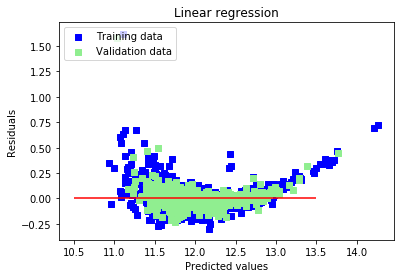

In [106]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

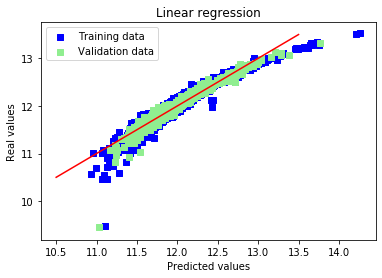

In [107]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

### Linear Regression with Ridge regularization 

In [ ]:
# X - Multi- Variable Regression
# 35 Correlated Numeric Variable to SalePrice
X = house[['OverallQual','GrLivArea','GarageCars','GarageArea', 'TotalBsmtSF','YearBuilt','1stFlrSF','YearRemod/Add','GarageYrBlt','FullBath','TotRmsAbvGrd','Fireplaces', 'MasVnrArea','BsmtFinSF1','LotFrontage','WoodDeckSF', 'OpenPorchSF','HalfBath','BsmtFullBath','2ndFlrSF','LotArea','BsmtUnfSF','BedroomAbvGr','ScreenPorch','PoolArea','3SsnPorch','BsmtFinSF2','MiscVal','BsmtHalfBath','Order','YrSold','LowQualFinSF','OverallCond','KitchenAbvGr','EnclosedPorch', 'SalePrice']]
y = X.SalePrice

In [123]:
# 2* Ridge
RidgeCV()
ridge = RidgeCV(alphas = [0.01, 0.1,10,20,30,60,90])


In [124]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+01, 2.e+01, 3.e+01, 6.e+01, 9.e+01]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [125]:
ridge.fit(X_test, y_test)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+01, 2.e+01, 3.e+01, 6.e+01, 9.e+01]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [126]:
print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

Ridge RMSE on Training set : 0.16942408990962654
Ridge RMSE on Test set : 0.15357140241791575


In [130]:
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

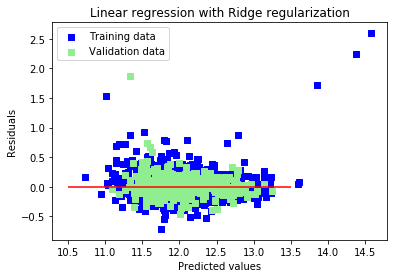

In [131]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

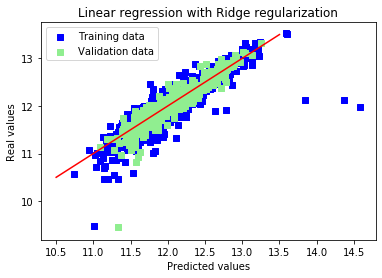

In [132]:
# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [134]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'